# Compare power between various runs for all wind farms (Stable)

In [1]:
# Load the libraries                                                                                                                        

import numpy             as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import xarray as xr
#import argparse
import os
import pandas as pd
import glob

import yaml as yaml
Loader=yaml.safe_load

# Make all plots inline 
%matplotlib inline

In [2]:
def loadyamldef(yamlfile, extradict={}):
    with open(yamlfile) as f:
        returndict = Loader(f)
    # Get the path to yamlfile
    dirpath = os.path.dirname(yamlfile)
    returndict['dirpath'] = dirpath
    # override any entries in the file
    for k,g in extradict.items():
        returndict[k] = g
    return returndict

def getturblist(yamldef, group):
    turbinegroups = yamldef['turbinegroups']
    # First check to make sure that the group exists:
    if group not in turbinegroups:
        return None
    
    dirpath=yamldef['dirpath']
    cwd = os.getcwd()
    os.chdir(dirpath)
    if 'globpattern' in turbinegroups[group]:
        # Load files from the glob pattern:
        outfilelist = glob.glob(turbinegroups[group]['globpattern'])
    else:
        outfilelist = turbinegroups[group]['filelist']
    outfilelist = [os.path.abspath(x) for x in outfilelist]
    os.chdir(cwd)
    return outfilelist

def avgturbpower(yamldef, group, delim=' '):
    """
    Average turbine power from a bunch of turbines
    """
    turblist = getturblist(yamldef, group)
    avgpower = None
    skiprows = yamldef['skiprows'] if 'skiprows' in yamldef else 0
    for ifile, turbfile in enumerate(turblist):
        dat = np.loadtxt(turbfile, skiprows=skiprows, delimiter=delim)
        if ifile == 0:
            avgpower = dat
        else:
            avgpower += dat
    avgpower /= len(turblist)
    return avgpower

def setfigtextsize(ax, fsize):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.yaxis.get_offset_text(), ax.xaxis.get_offset_text(), ] + ax.get_xticklabels() + ax.get_yticklabels() ):
        item.set_fontsize(fsize)

In [3]:
AllFigures = [
    {'title':'King Plains avg. turbine power (all turbines)',
     'turbinegroup':'allturbines',
     'xlim':[0, 1500],
     'figsize':(10,4),
     'datasets':[
        ['DATA_Summit_amrwind_eastkp/KingPlainsTurbines.yaml', {'label':'AMR-Wind Summit (East KP)', 'delim':',', 'plotargs':{'color':'pink'}}],
        ['DATA_SNL_naluwind_stable/NaluTurbines.yaml', {'label':'Nalu-Wind SNL', 'plotargs':{'color':'g'}}],
        ['DATA_FLORIS_TurbOPark_stable/KingPlains.yaml', {'label':'FLORIS TurbOPark', 'plotargs':{'color':'b'}}],        
        ],
    },
    {'title':'King Plains avg. turbine power (frontrow)',
     'turbinegroup':'frontrow',
     'xlim':[0, 1500],
     'figsize':(10,4),
     'datasets':[
        ['DATA_Summit_amrwind_eastkp/KingPlainsTurbines.yaml', {'label':'AMR-Wind Summit (East KP)', 'delim':',', 'plotargs':{'color':'pink'}}],
        ['DATA_SNL_naluwind_stable/NaluTurbines.yaml', {'label':'Nalu-Wind SNL', 'plotargs':{'color':'g'}}],
        ['DATA_FLORIS_TurbOPark_stable/KingPlains.yaml', {'label':'FLORIS TurbOPark', 'plotargs':{'color':'b'}}],  
        ],
    },
]

***** King Plains avg. turbine power (all turbines) *****
Loading AMR-Wind Summit (East KP)
Loading Nalu-Wind SNL
Loading FLORIS TurbOPark
***** King Plains avg. turbine power (frontrow) *****
Loading AMR-Wind Summit (East KP)
Loading Nalu-Wind SNL
Loading FLORIS TurbOPark


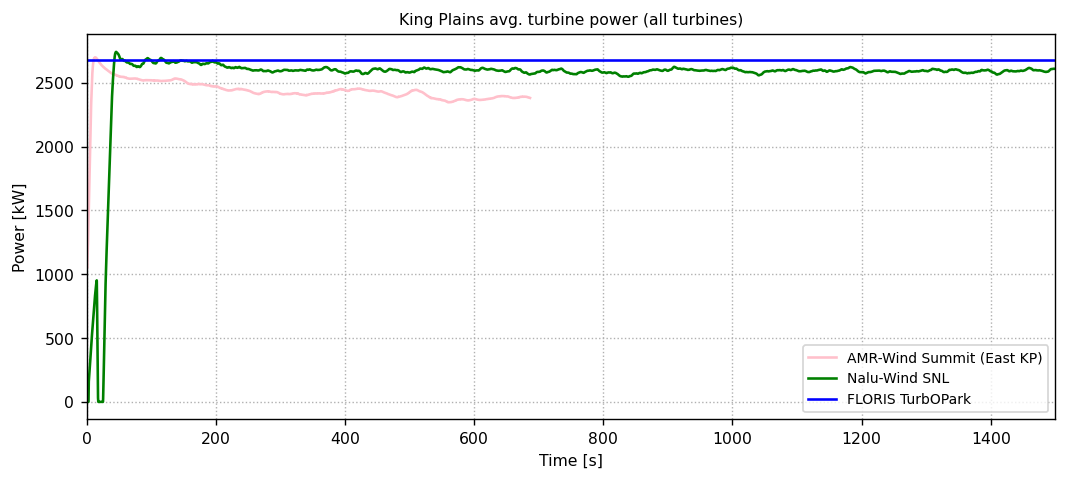

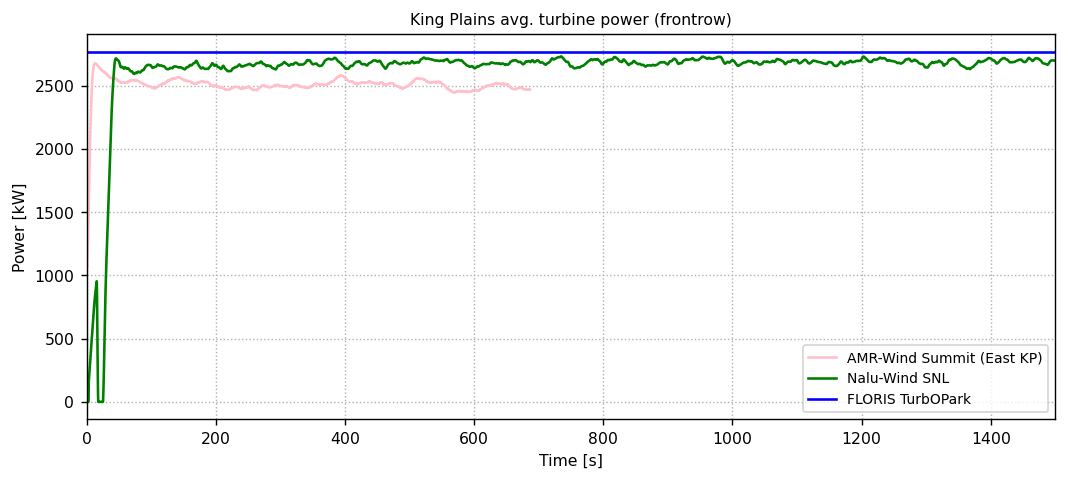

In [4]:
fontsize=9

for datadict in AllFigures:
    datadefs = []
    datasets = datadict['datasets']
    turbinegroup = datadict['turbinegroup']
    title        = datadict['title']
    figsize      = datadict['figsize'] if 'figsize' in datadict else (6,4)    
    print('***** '+title+' *****')
    for data in datasets:
        datadefs.append(loadyamldef(data[0], extradict=data[1]))
    fig, ax = plt.subplots(1,1,figsize=figsize, dpi=125)
    for data in datadefs:
        print('Loading '+data['label'])
        plotargs = data['plotargs'] if 'plotargs' in data else {}
        plotargs['label'] = data['label']
        delim = data['delim'] if 'delim' in data else ' '
        farmavg = avgturbpower(data, turbinegroup, delim=delim)
        ax.plot(farmavg[:,0], farmavg[:,1], **plotargs)
        
    # Format and label figure
    ax.legend(prop={'size':fontsize-1})
    ax.grid(ls=':')
    if 'xlim' in datadict: ax.set_xlim(datadict['xlim'])
    if 'ylim' in datadict: ax.set_ylim(datadict['ylim'])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Power [kW]')
    ax.set_title(title)
    setfigtextsize(ax, fontsize)